In [1]:
import numpy as np
from scipy.optimize import least_squares
from scipy.constants import physical_constants
from scipy import stats
import scipy.special as sps

import matplotlib.pyplot as plt
import matplotlib as mpl


In [46]:
F = physical_constants['Faraday constant'][0]
R = physical_constants['molar gas constant'][0]

T = 298.15
rho_0 = 4.87 #NCM density g/cm^3 (fully lithiated!)
D = 10**-10
c = 0.05 #Lithium concentration in mol/cm^3
W = 20

mass = 0.010 #mass of NCM in the cathode


def Z_w_no_area(c,W,D):
    return (R*T/(F**2)*1/c*(W/(np.sqrt(D))))

#I like this color
main_c = (0,0,0.7,0.75)

Text(0.5, 1.0, 'Poisson distribution')

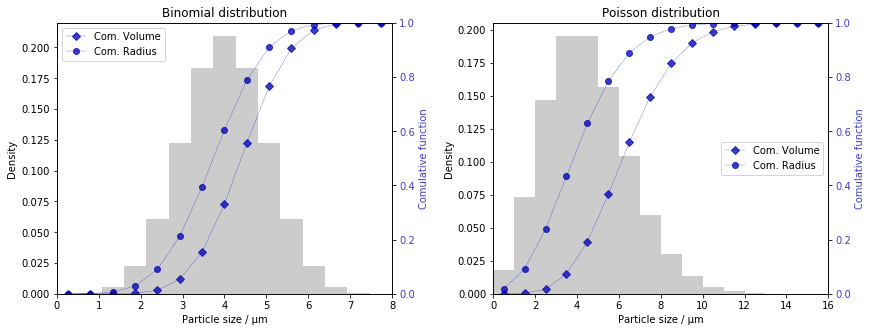

In [27]:
def r_binomial(n):
    f = np.array([sps.comb(n-1, i, exact=True) for i in range(n)], dtype='O')
    f = np.float64(f)/(np.float64(f).sum())
    if not np.allclose(f.sum(), 1.0):
        raise ValueError("The distribution is not properly normalized. Density sum = %".format(f.sum()))
        
    return f

def get_norm_dist(n_bins, radii):
    if n_bins > 1:
        bin_size = (radii[1]-radii[0])/n_bins
        p_sizes = [(radii[0]+(i*bin_size+bin_size/2)) for i in range(n_bins)]

        #generates the distribution of radii
        dist_NCM_r = np.array([i for i in r_binomial(n_bins)])
        p_volumes = np.array([i**3 for i in p_sizes])

        #normalize the volume distribution
        dist_NCM_vol = np.array([i*k for i,k in zip(dist_NCM_r,p_volumes)])
        volume_sum = dist_NCM_vol.sum()
        dist_NCM_vol = np.array([i/volume_sum for i in dist_NCM_vol])
        return (p_sizes,dist_NCM_r,dist_NCM_vol)
    else:
        return (radii[1]/2,1,1)

def get_poisson_dist(mu,n_bins):
    if n_bins > 1:
        dist = [stats.poisson.pmf(i, mu, loc=0) for i in range(n_bins)]
        p_sizes = [(0.5+i) for i in range(n_bins)]
        p_volumes = np.array([i**3 for i in p_sizes])

        #normalize the volume distribution
        dist_NCM_vol = np.array([i*k for i,k in zip(dist,p_volumes)])
        volume_sum = dist_NCM_vol.sum()
        dist_NCM_vol = np.array([i/volume_sum for i in dist_NCM_vol])
        return (p_sizes,dist,dist_NCM_vol)
    else:
        return (mu,1,1)

    
#generates data for the binomial distribution    
r_range = (0,8)
n_bins = 15
p_sizes,dist_NCM_r,dist_NCM_vol = get_norm_dist(n_bins, r_range)

# plotting jargon
fig, (ax, ax3) = plt.subplots(1, 2, figsize=(12, 4.5),constrained_layout=True, num='seaborn-notebook')
ax.bar(p_sizes, dist_NCM_r, label='Radius Distr.', width=(r_range[1]-r_range[0])/len(p_sizes), align='center', color=(0,0,0,0.2))
ax.set_ylabel('Density')
ax.set_xlabel('Particle size / µm')
ax2 = ax.twinx()
ax2.plot(p_sizes, np.cumsum(dist_NCM_vol), label='Com. Volume', color=main_c, linewidth=0.3, marker='D')
ax2.plot(p_sizes, np.cumsum(dist_NCM_r), label='Com. Radius', color=main_c, linewidth=0.3, marker='o')
ax2.set_ylabel('Comulative function', color = main_c)
ax2.tick_params(axis='y', labelcolor= main_c)
ax2.set_ylim(0,1)
ax2.set_xlim(r_range)
ax2.legend()
plt.title('Binomial distribution')

#generates data for the poisson distribution
mean_size = 4
n_bins = 16
p_sizes,dist_NCM_r,dist_NCM_vol = get_poisson_dist(mean_size, n_bins)

#plotting jargon
ax3.bar(p_sizes, dist_NCM_r, label='Radius Distr.', width=1, align='center', color=(0,0,0,0.2))
ax3.set_ylabel('Density')
ax3.set_xlabel('Particle size / µm')
ax3.set_xlim((0,n_bins))
ax4 = ax3.twinx()
ax4.plot(p_sizes, np.cumsum(dist_NCM_vol), label='Com. Volume', color=main_c, linewidth=0.3, marker='D')
ax4.plot(p_sizes, np.cumsum(dist_NCM_r), label='Com. Radius', color=main_c, linewidth=0.3, marker='o')
ax4.set_ylabel('Comulative function', color = main_c)
ax4.tick_params(axis='y', labelcolor= main_c)
ax4.set_ylim(0,1)
ax4.set_xlim(0,n_bins)
ax4.legend(loc='center right')
plt.title('Poisson distribution')

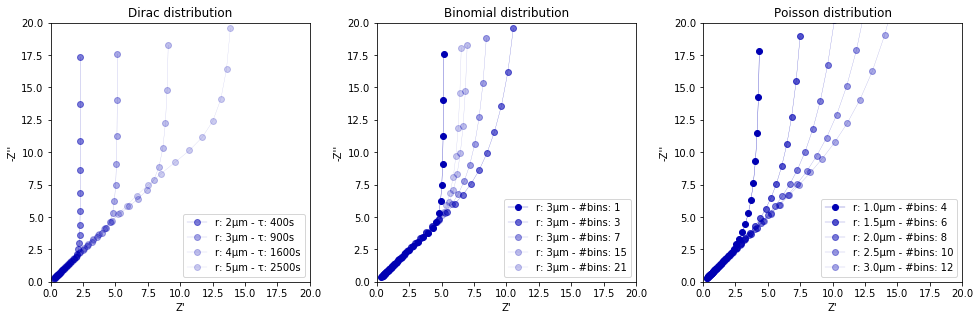

In [50]:
#define the frequency range from 1 Hz to 0.001 Hz, 30 points in totalin logaritmic space
f_range = np.logspace(0,-3,30)

#single frequency response of a 'Warbug-open' element
def w_open(freq, Z_w, tau):
    return (Z_w/(np.sqrt(1j*freq))*(1/np.tanh(np.sqrt(1j*freq*tau))))

#calculates the impedance in the given frequncy range 
def z_warburg_o(radius, fraction, f_range, c, W, D):
    #define partile surface area and volume
    p_area = 4*np.pi*(radius/10**4)**2
    p_volume = 4/3*np.pi*(radius/10**4)**3
    
    # number of particles given their fration in the mass of cathode
    n_particles = (mass/rho_0)*fraction*(1/p_volume)
    
    #calculates the Warburg diffusion resistance and characteristic time
    Z_w = Z_w_no_area(c, W, D) / (p_area * n_particles)
    tau = (radius/10**4)**2/D
    
    #generates the impedance spectra
    Z = np.array([w_open(f, Z_w, tau) for f in f_range])
    return (Z,tau)

def paral_imp(p_sizes,dist_NCM_vol,f_range, c, W, D):
        list_Imp = []
        for size, fraction in zip(p_sizes,dist_NCM_vol):
            Imp, tau = z_warburg_o(size,fraction,f_range, c, W, D)
            list_Imp.append(Imp)
        Z_dist = stats.hmean(list_Imp, axis=0)/len(list_Imp)
        return Z_dist
    


# initial set of particle sizes, number of bins
set_1 = [2,3,4,5]
set_2 = [1,3,7,15,21]
set_3 = [1,1.5,2,2.5,3]
        
# create the figure
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5),constrained_layout=True, num='seaborn-notebook')

# uses the radius in set_1 to calculate the impedance and plot in the first graph
for i in set_1:
    Imp, tau = z_warburg_o(i,1,f_range, c, W, D)
    axes[0].plot(np.real(Imp), -np.imag(Imp) , label='r: {}µm - τ: {:.0f}s'.format(i, tau), linewidth=0.3, marker='o', color=(0,0,0.7,1/i))
    axes[0].set_title("Dirac distribution")
    
# uses the bin sizes in set_2 to calculate the distribution, then the impedance and plot in the second graph
for i in set_2:
    r_range = (0,6)
    p_sizes,dist_NCM_r,dist_NCM_vol = get_norm_dist(i, r_range)
    Z_dist = np.zeros(30)
    if type(p_sizes) == list:
        Z_dist = paral_imp(p_sizes,dist_NCM_vol,f_range,c, W, D)
    else:
        Z_dist, tau = z_warburg_o(p_sizes,dist_NCM_vol,f_range, c, W, D)       
    axes[1].plot(np.real(Z_dist), -np.imag(Z_dist) , label='r: {:.0f}µm - #bins: {:.0f}'.format(r_range[1]/2, i), linewidth=0.3, marker='o', color=(0,0,0.7,1/np.sqrt(i)))
    axes[1].set_title('Binomial distribution')

    # uses the bin sizes in set_2 to calculate the distribution, then the impedance and plot in the second graph
for i in set_3:
    p_sizes,dist_NCM_r,dist_NCM_vol = get_poisson_dist(i, int(4*i))
    Z_dist = np.zeros(30)
    if type(p_sizes) == list:
        Z_dist = paral_imp(p_sizes,dist_NCM_vol,f_range, c, W, D)
    else:
        Z_dist, tau = z_warburg_o(p_sizes,dist_NCM_vol,f_range, c, W, D)       
    axes[2].plot(np.real(Z_dist), -np.imag(Z_dist) , label='r: {:.1f}µm - #bins: {:.0f}'.format(i, int(4*i)), linewidth=0.3, marker='o', color=(0,0,0.7,1/i))
    axes[2].set_title("Poisson distribution")
    
#prettify the plots
for ax in axes:
    ax.set_ylabel("-Z''")
    ax.set_xlabel("Z'")
    ax.set_aspect(aspect='equal')
    ax.legend(loc='lower right')
    ax.set_ylim(0,20)
    ax.set_xlim(0,20)

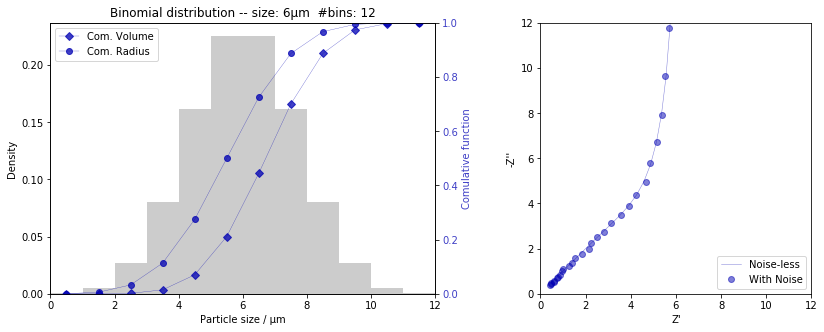

In [147]:
#Here I generated a binomial distribution of particle sizes
r_range = (0,12)
n_bins = 12
p_sizes,dist_NCM_r,dist_NCM_vol = get_norm_dist(n_bins, r_range)

# and now calculate its impedance
f_range = np.logspace(0,-3,30)
Diff_model = 5*10**-10
Z_model = paral_imp(p_sizes,dist_NCM_vol,f_range, c, W, Diff_model)

# this generates complex white noise, normally distribiuted, to be added to simulate a measurment
Z_noise = 0.04*np.random.randn(30, 2).view(np.complex128)[...,0]
Z_meas = np.add(Z_model, Z_noise)

# plotting jargon
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5),constrained_layout=True, num='seaborn-notebook')
axes[0].bar(p_sizes, dist_NCM_r, label='Radius Distr.', width=(r_range[1]-r_range[0])/len(p_sizes), align='center', color=(0,0,0,0.2))
axes[0].set_ylabel('Density')
axes[0].set_xlabel('Particle size / µm')
ax2 = axes[0].twinx()
ax2.plot(p_sizes, np.cumsum(dist_NCM_vol), label='Com. Volume', color=main_c, linewidth=0.3, marker='D')
ax2.plot(p_sizes, np.cumsum(dist_NCM_r), label='Com. Radius', color=main_c, linewidth=0.3, marker='o')
ax2.set_ylabel('Comulative function', color = main_c)
ax2.tick_params(axis='y', labelcolor= main_c)
ax2.set_ylim(0,1)
ax2.set_xlim(r_range)
ax2.legend()
plt.title('Binomial distribution -- size: {:.0f}µm  #bins: {}'.format(r_range[1]/2,n_bins))

axes[1].plot(np.real(Z_model), -np.imag(Z_model) , label='Noise-less', linewidth=0.5, color=(0,0,0.7,0.5))
axes[1].plot(np.real(Z_meas), -np.imag(Z_meas) , label='With Noise', linewidth=0, marker='o', color=(0,0,0.7,0.5))
axes[1].set_ylabel("-Z''")
axes[1].set_xlabel("Z'")
axes[1].set_aspect(aspect='equal')
axes[1].legend(loc='lower right')
axes[1].set_ylim(0,12)
axes[1].set_xlim(0,12)

plt.show()

`xtol` termination condition is satisfied.


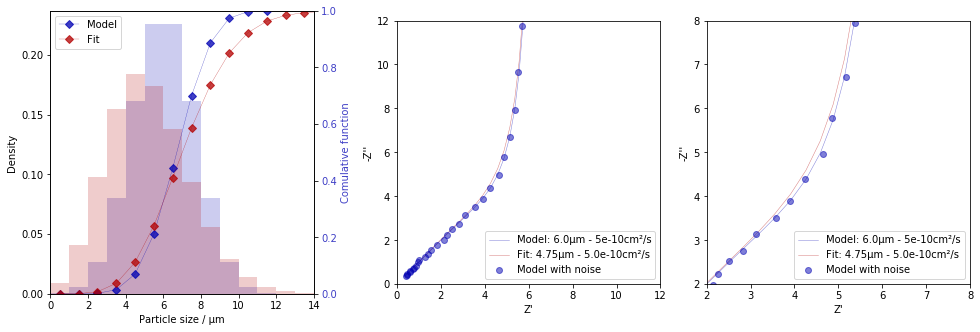

In [203]:
# here I define the residual function that the least_squares method minimize. 

def Z_residuals_magnitude(par_dist, Z_meas):
    szs,dist_r,dist_vol = get_poisson_dist(par_dist[0], int(4*par_dist[0]))
    Z_dist = paral_imp(szs,dist_vol,f_range, c, W, par_dist[1])
    return np.absolute(Z_meas - Z_dist)

par_dist_0 = np.array([3,10**-12])  # initial guess

solution = least_squares(Z_residuals_magnitude, par_dist_0, bounds = [(1,10**-14),(10,10**-8)],
                         args=(Z_meas, ), xtol = 10**-15)
print(solution.message)


#data for plots
p_sizes_fit,dist_NCM_r_fit,dist_NCM_vol_fit = get_poisson_dist(solution.x[0], int(4*solution.x[0]))

Z_model = paral_imp(p_sizes,dist_NCM_vol,f_range, c, W, 5*10**-10)
Z_fit = paral_imp(p_sizes_fit,dist_NCM_vol_fit,f_range, c, W, solution.x[1])


# plotting jargon
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5),constrained_layout=True, num='seaborn-notebook')
axes[0].bar(p_sizes, dist_NCM_r, label='Model dist.', width=(r_range[1]-r_range[0])/len(p_sizes), align='center', color=(0,0,0.7,0.2))
axes[0].bar(p_sizes_fit, dist_NCM_r_fit, label='Fit dist.', width=1, align='center', color=(0.7,0,0,0.2))
axes[0].set_ylabel('Density')
axes[0].set_xlabel('Particle size / µm')
ax2 = axes[0].twinx()
ax2.plot(p_sizes, np.cumsum(dist_NCM_vol), label='Model', color=main_c, linewidth=0.3, marker='D')
#ax2.plot(p_sizes, np.cumsum(dist_NCM_r), label='Com. Radius', color=main_c, linewidth=0.3, marker='o')
ax2.plot(p_sizes_fit, np.cumsum(dist_NCM_vol_fit), label='Fit', color=(0.7,0,0,0.75), linewidth=0.3, marker='D')
#ax2.plot(p_sizes_fit, np.cumsum(dist_NCM_r_fit), label='Com. Radius', color=(0.7,0,0,0.75), linewidth=0.3, marker='o')
ax2.set_ylabel('Comulative function', color = main_c)
ax2.tick_params(axis='y', labelcolor= main_c)
ax2.set_ylim(0,1)
ax2.set_xlim(0, max(r_range[1], int(3*solution.x[0])))
ax2.legend()


axes[1].plot(np.real(Z_model), -np.imag(Z_model) , label='Model: {}µm - {}cm\u00b2/s'.format(r_range[1]/2, Diff_model), linewidth=0.5, color=(0,0,0.7,0.5))
axes[1].plot(np.real(Z_model), -np.imag(Z_fit) , label='Fit: {:.2f}µm - {:.1e}cm\u00b2/s'.format(solution.x[0],solution.x[1]), linewidth=0.5, color=(0.7,0,0,0.5))
axes[1].plot(np.real(Z_meas), -np.imag(Z_meas) , label='Model with noise', linewidth=0, marker='o', color=(0,0,0.7,0.5))

axes[1].set_ylabel("-Z''")
axes[1].set_xlabel("Z'")
axes[1].set_aspect(aspect='equal')
axes[1].legend(loc='lower right')
axes[1].set_ylim(0,12)
axes[1].set_xlim(0,12)

axes[2].plot(np.real(Z_model), -np.imag(Z_model) , label='Model: {}µm - {}cm\u00b2/s'.format(r_range[1]/2, Diff_model), linewidth=0.5, color=(0,0,0.7,0.5))
axes[2].plot(np.real(Z_model), -np.imag(Z_fit) , label='Fit: {:.2f}µm - {:.1e}cm\u00b2/s'.format(solution.x[0],solution.x[1]), linewidth=0.5, color=(0.7,0,0,0.5))
axes[2].plot(np.real(Z_meas), -np.imag(Z_meas) , label='Model with noise', linewidth=0, marker='o', color=(0,0,0.7,0.5))

axes[2].set_ylabel("-Z''")
axes[2].set_xlabel("Z'")
axes[2].set_aspect(aspect='equal')
axes[2].legend(loc='lower right')
axes[2].set_ylim(2,8)
axes[2].set_xlim(2,8)

plt.show()